In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import spacy

class CBOWModel(nn.Module):
    def __init__(self, embedding_size, vocab_size):
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size) # Embedding layer
        self.linear = nn.Linear(embedding_size, vocab_size) # Linear layer for output
    
    def forward(self, inputs):
        embeds = self.embeddings(inputs).mean(dim=1).squeeze(1) # Average embeddings.
        output = self.linear(embeds)
        return output
    
def create_dataset():
    with open('eng_text.txt', 'r') as f:
        raw_text = f.read().lower()
    
    # Tokenization using spaCy
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(raw_text)
    tokenized_text = [token.text for token in doc if not token.is_punct and not token.is_space]
    vocab = set(tokenized_text)
    
    # Create word to index mapping and vice versa
    word_to_ix = {word: i for i, word in enumerate(vocab)}
    ix_to_word = {i: word for word, i in word_to_ix.items()}
    
    # Create CBOW dataset with two words before and after the target word
    data = []
    for i in range(2, len(tokenized_text) - 2):
        # keep words for context, then map to indices once (avoid double-mapping)
        context_words = [tokenized_text[i-2], 
                         tokenized_text[i-1], 
                         tokenized_text[i+1], 
                         tokenized_text[i+2]]
        target_word = tokenized_text[i]
        context_idx = [word_to_ix[w] for w in context_words]
        target_idx = word_to_ix[target_word]
        data.append((context_idx, target_idx))
        
    return data, word_to_ix, ix_to_word

In [38]:
EMBD_SZE = 16
data, word_to_ix, ix_to_word = create_dataset()
loss_function = nn.CrossEntropyLoss()
model = CBOWModel(EMBD_SZE, len(word_to_ix))
optimizer = optim.Adam(model.parameters(), lr=0.001)


context_data = torch.tensor([context for context, target in data], dtype=torch.long)
target_data = torch.tensor([target for context, target in data], dtype=torch.long)
dataset = torch.utils.data.TensorDataset(context_data, target_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

## Training Loop
EPOCHS = 2000
losses = []
for epoch in range(EPOCHS):
    total_loss = 0
    for context_batch, target_batch in dataloader:
        model.zero_grad()
        output = model(context_batch)
        loss = loss_function(output, target_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(dataloader)}')

Epoch 100, Loss: 2.9880706494854343
Epoch 200, Loss: 1.6321248104495387
Epoch 300, Loss: 0.9119171452137732
Epoch 400, Loss: 0.48368275502035696
Epoch 500, Loss: 0.23314116678891644
Epoch 600, Loss: 0.09863935374925213
Epoch 700, Loss: 0.03604022918208953
Epoch 800, Loss: 0.012691712983313107
Epoch 900, Loss: 0.004935443596613984
Epoch 1000, Loss: 0.002534861452013795
Epoch 1100, Loss: 0.0018717176273874488
Epoch 1200, Loss: 0.00161354881522364
Epoch 1300, Loss: 0.0015698854976430848
Epoch 1400, Loss: 0.0014979078813109569
Epoch 1500, Loss: 0.0015077572051077663
Epoch 1600, Loss: 0.001479538841833104
Epoch 1700, Loss: 0.0014755095859451403
Epoch 1800, Loss: 0.001501887922436877
Epoch 1900, Loss: 0.0015496456577599174
Epoch 2000, Loss: 0.001543686287394878


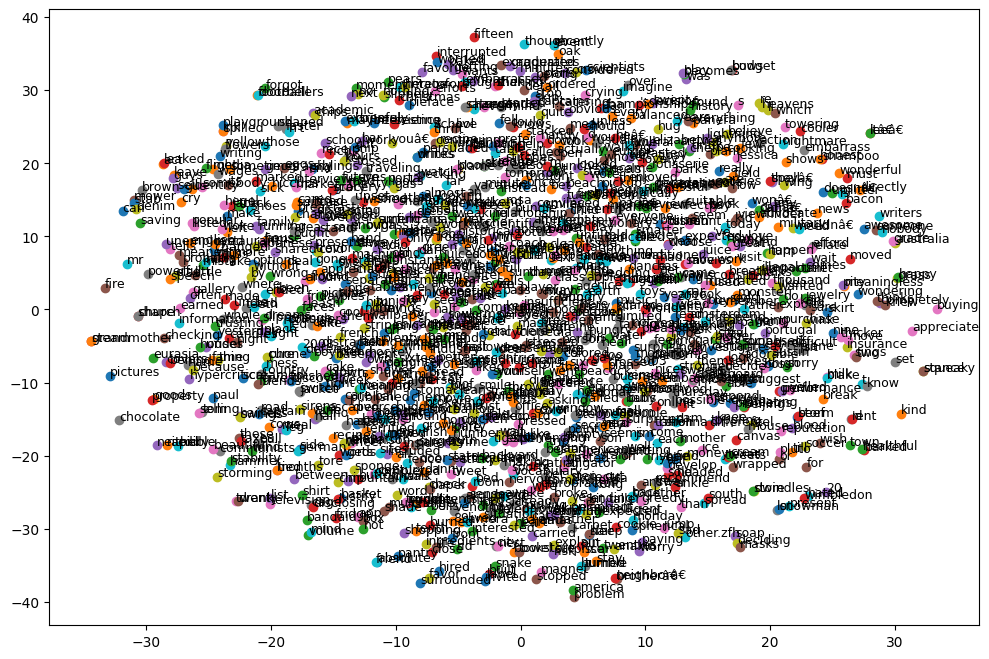

In [39]:
## Visualizing Embeddings

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract embeddings
embeddings = model.embeddings.weight.data.cpu().numpy()

# Reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(12, 8))
for i, word in enumerate(word_to_ix):
    x, y = embeddings_2d[i, 0], embeddings_2d[i, 1]
    plt.scatter(x, y)
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()


In [40]:
import torch.nn.functional as F

def find_similar_words(word, top_k=3):
    if word not in word_to_ix:
        print(f"Word '{word}' not in vocabulary")
        return
    
    # Get the embedding of the given word
    word_idx = word_to_ix[word]
    word_embedding = model.embeddings.weight[word_idx]  # shape: (embedding_dim,)
    
    # Compute cosine similarity with all embeddings
    all_embeddings = model.embeddings.weight  # shape: (vocab_size, embedding_dim)
    cos_sim = F.cosine_similarity(word_embedding.unsqueeze(0), all_embeddings)
    
    # Exclude the word itself
    cos_sim[word_idx] = -1
    
    # Get top_k indices
    top_k_idx = torch.topk(cos_sim, top_k).indices.tolist()
    
    # Map indices back to words
    similar_words = [ix_to_word[i] for i in top_k_idx]
    
    return similar_words

In [52]:
print(find_similar_words('total', top_k=3))

['beautiful', 'relationship', 'today']


In [42]:
import torch
from torch.utils.tensorboard import SummaryWriter

# Extract embeddings
embeddings = model.embeddings.weight.data

# Create a metadata file with words
with open("metadata.tsv", "w", encoding="utf-8") as f:
    for word in word_to_ix:
        f.write(word + "\n")

# Initialize TensorBoard writer
writer = SummaryWriter("runs/cbow_embeddings")

# Add embeddings to TensorBoard
writer.add_embedding(embeddings, metadata=list(word_to_ix.keys()), tag="CBOW Embeddings")
writer.close()


In [43]:
# # using nltk brown dataset

# # import nltk
# # nltk.download('brown') 

# from nltk.corpus import brown

# # Get sentences from the Brown Corpus
# sentences = brown.sents()  # each sentence is a list of words

# # Lowercase and remove punctuation
# import string
# tokenized_text = []
# for sent in sentences:
#     for word in sent:
#         word = word.lower()
#         if word not in string.punctuation:
#             tokenized_text.append(word)

# # Create vocabulary and mappings
# vocab = set(tokenized_text)
# word_to_ix = {word: i for i, word in enumerate(vocab)}
# ix_to_word = {i: word for word, i in word_to_ix.items()}


# # Create CBOW dataset with two words before and after the target word
# data = []
# window_size = 2
# for i in range(window_size, len(tokenized_text) - window_size):
#     context = [
#         word_to_ix[tokenized_text[i - 2]],
#         word_to_ix[tokenized_text[i - 1]],
#         word_to_ix[tokenized_text[i + 1]],
#         word_to_ix[tokenized_text[i + 2]]
#     ]
#     target = word_to_ix[tokenized_text[i]]
#     data.append((context, target))

# # convert to tensors
# import torch

# context_data = torch.tensor([context for context, target in data], dtype=torch.long)
# target_data = torch.tensor([target for context, target in data], dtype=torch.long)

# dataset = torch.utils.data.TensorDataset(context_data, target_data)
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)


In [44]:
# EMBD_SZE = 100
# loss_function = nn.CrossEntropyLoss()
# model = CBOWModel(EMBD_SZE, len(word_to_ix))
# optimizer = optim.Adam(model.parameters(), lr=0.001)


# ## Training Loop
# EPOCHS = 10  
# for epoch in range(EPOCHS):
#     total_loss = 0
#     for context_batch, target_batch in dataloader:
#         model.zero_grad()
#         output = model(context_batch)
#         loss = loss_function(output, target_batch)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(dataloader):.4f}")

In [45]:
# import torch
# from torch.utils.tensorboard import SummaryWriter

# # Extract embeddings
# embeddings = model.embeddings.weight.data

# # Create a metadata file with words
# with open("metadata.tsv", "w", encoding="utf-8") as f:
#     for word in word_to_ix:
#         f.write(word + "\n")

# # Initialize TensorBoard writer
# writer = SummaryWriter("runs/cbow_embeddings")

# # Add embeddings to TensorBoard
# writer.add_embedding(embeddings, metadata=list(word_to_ix.keys()), tag="CBOW Embeddings")
# writer.close()


In [46]:
# import torch.nn.functional as F

# def find_similar_words(word, top_k=3):
#     if word not in word_to_ix:
#         print(f"Word '{word}' not in vocabulary")
#         return
    
#     # Get the embedding of the given word
#     word_idx = word_to_ix[word]
#     word_embedding = model.embeddings.weight[word_idx]  # shape: (embedding_dim,)
    
#     # Compute cosine similarity with all embeddings
#     all_embeddings = model.embeddings.weight  # shape: (vocab_size, embedding_dim)
#     cos_sim = F.cosine_similarity(word_embedding.unsqueeze(0), all_embeddings)
    
#     # Exclude the word itself
#     cos_sim[word_idx] = -1
    
#     # Get top_k indices
#     top_k_idx = torch.topk(cos_sim, top_k).indices.tolist()
    
#     # Map indices back to words
#     similar_words = [ix_to_word[i] for i in top_k_idx]
    
#     return similar_words

In [47]:
# print(find_similar_words("up"))

In [53]:
## Saving the embeddings

torch.save(model.embeddings.weight, "runs/cbow_embeddings_eng.pt")